In [22]:
# @title imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from skimage.segmentation import slic, mark_boundaries

import torchvision
import torchvision.models as models

import math

import os

from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision.datasets import MNIST, CIFAR100
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import pickle

import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage import filters, graph
import torch
import numpy as np
from torch_geometric.utils.convert import from_networkx
from torchvision.transforms import Resize

In [3]:
transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize(0, 1),
])
dataset = CIFAR100(root="../data/image/CIFAR100", download=True, transform=transform)

Files already downloaded and verified


# SLIC

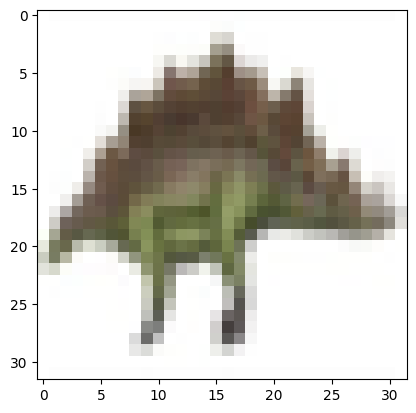

In [88]:
img = dataset[1][0].permute(1, 2, 0)

plt.imshow(img)

tensor([1, 2, 3, 4, 5, 6, 7])

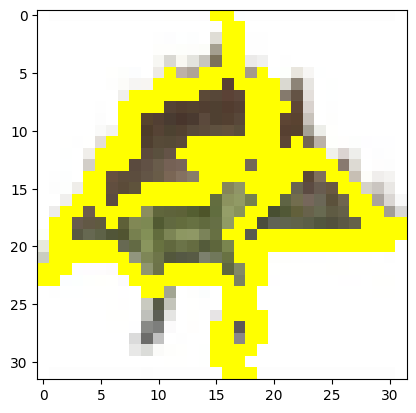

In [60]:
seg = slic(img.numpy(), n_segments=16, compactness=0.5, channel_axis=2)

plt.imshow(mark_boundaries(img.numpy(), seg))

torch.tensor(seg).unique()

In [92]:
def extract_patches(img, seg, reg, num_channels):
    imgs, masks, coords = [], [], []
    for idx in range(len(reg)):
        x_min, y_min, x_max, y_max = reg[idx].bbox
        cropped_image = img[:, x_min:x_max, y_min:y_max]
        cropped_mask = seg[x_min:x_max, y_min:y_max]
        cropped_mask = cropped_mask == idx + 1
        imgs.append(cropped_image)
        masks.append(cropped_mask)
        coords.append(reg[idx].centroid)

    return imgs, masks, coords

def image_to_SLIC_graph(img, n_segments=14*14, compactness=0.5, save_img=False):
    assert type(img) == torch.Tensor and len(img.shape) == 3 and (img.shape[0] == 1 or img.shape[0] == 3)

    num_channels = img.shape[0]
    img_np = np.array(img.permute(1, 2, 0)) if num_channels == 3 else np.array(img.squeeze(0))
    seg = slic(img_np, n_segments=n_segments, compactness=compactness, channel_axis=-1 if num_channels == 3 else None)
    reg = regionprops(seg)

    edge_boundary = filters.sobel(img_np if num_channels == 1 else np.mean(img_np, axis=2))
    nx_g = graph.rag_boundary(seg, edge_boundary)

    g = from_networkx(nx_g)
    if save_img:
        g.img = img_np
        g.seg = seg
        g.edge_boundary = edge_boundary

    imgs, masks, coords = extract_patches(img, seg, reg, num_channels)
    g.centroid = torch.Tensor([coords[label[0] - 1] for label in g.labels])
    g.imgs = [imgs[label[0] - 1] for label in g.labels]
    g.masks = [masks[label[0] - 1] for label in g.labels]

    return g


g = image_to_SLIC_graph(dataset[248][0], n_segments=16, compactness=0.001, save_img=True)
g

ValueError: zero-size array to reduction operation maximum which has no identity

In [87]:
def resize_stack_slic_graph_patches(data, size):
    r = Resize(size)
    
    for g in data:
        g.imgs = [torch.Tensor(img).unsqueeze(0) for img in g.imgs]

        g.imgs = [r(img) for img in g.imgs]
        g.imgs = torch.cat(g.imgs, dim=0)
        
        if len(g.imgs.shape) == 3:
            g.imgs = g.imgs.unsqueeze(1)
    
    return data

resize_stack_slic_graph_patches([g], (8, 8))

[Data(edge_index=[2, 20], labels=[7, 1], weight=[20], count=[20], num_nodes=7, img=[32, 32, 3], seg=[32, 32], edge_boundary=[32, 32], centroid=[7, 2], imgs=[7, 3, 8, 8], masks=[7])]

# Stats

In [4]:
import pickle
import os
import numpy as np

path_name = "../data/models/vit_cifar100/"

res = []
for file_name in os.listdir(path_name):
    res.append(pickle.load(open(path_name + file_name, "rb")))

res[0].keys()

dict_keys(['train_accs', 'val_accs', 'test_accs', 'train_losses', 'val_losses', 'test_losses'])

In [6]:
len(res)

1

In [7]:
def get_test_acc(res):
    min_val_loss, test = float("inf"), 0
    
    for i in range(len(res["val_losses"])):
        if res["val_losses"][i] < min_val_loss:
            test = res["test_accs"][i]
            min_val_loss = res["val_losses"][i]
            
    return test

test_accs = np.array([get_test_acc(r) for r in res])
test_accs = {
    "vit": np.array([30.9,30.9,30.9,30.0,30.8,31.5,30.8,31.1,31.6,31.3,29.4]),
    "coordvit": np.array([30.7,31.2,31.9,31.6,30.2,31.7,31.7,31.5,31.7])
}

In [8]:
print("vit", test_accs["vit"].mean(), test_accs["vit"].std())
print("coordvit", test_accs["coordvit"].mean(), test_accs["coordvit"].std())

vit 30.836363636363636 0.6094300277125231
coordvit 31.355555555555554 0.5293835222031821


# Pooling for nodification

In [23]:
dataset = pickle.load(open("../data/image/CIFAR100/CIFAR_SLIC_graph_32_16_15.pkl", "rb"))

In [24]:
dataset[0].imgs[0].shape

torch.Size([3, 15, 29])

In [21]:
def resize_stack_slic_graph_patches(data, size):
    r = Resize(size)

    for g in data:
        for i in range(len(g.imgs)):
            g.imgs[i] = (torch.Tensor(g.imgs[i] * g.masks[i]) / torch.sum(g.masks[i], dim=(0, 1))).unsqueeze(0)
        # g.imgs = [torch.Tensor(g.imgs[i] * g.masks[i]).unsqueeze(0) for i in range(len(g.imgs))] 
        g.imgs = [r(img) for img in g.imgs]
        g.imgs = torch.cat(g.imgs, dim=0)

        if len(g.imgs.shape) == 3:
            g.imgs = g.imgs.unsqueeze(1)

    return data

def avgpool_stack_slic_graph_patches(data):
    for g in data:
        for i in range(len(g.imgs)):
            g.imgs[i] = (torch.Tensor(g.imgs[i] * g.masks[i]) / torch.sum(g.masks[i], dim=(0, 1))).unsqueeze(0)
        g.imgs = [r(img) for img in g.imgs]
        g.imgs = torch.cat(g.imgs, dim=0)

        if len(g.imgs.shape) == 3:
            g.imgs = g.imgs.unsqueeze(1)

    return data
    
    for g in data:
        for i in range(len(g.imgs)):
            g.imgs[i] = torch.sum(g.imgs[i] * g.masks[i], dim=(1, 2)) / torch.sum(g.masks[i], dim=(1, 2))
        g.imgs = torch.cat(g.imgs, dim=0)

    return data

avgpool_stack_slic_graph_patches(dataset[:5])

TypeError: sum() received an invalid combination of arguments - got (numpy.ndarray, dim=tuple), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)
